# DenseShift ResNet-18 on MNIST

This notebook contains the implementation of a DenseShift-enabled ResNet-18 model and training logic for MNIST. The code is organized into sections:
1. Importing Libraries
2. DenseShift Layer Components
3. ResNet Architecture
4. Training and Evaluation Functions
5. Main Training Loop and Plotting


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


## DenseShift Layer Components

In [2]:
class STEFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input_val):
        return (input_val > 0).float()

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output


In [3]:
class DenseShiftConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, T_val,
                 stride=1, padding=0, dilation=1, groups=1, bias=True, low_var_init_std=0.001):
        super(DenseShiftConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = (kernel_size, kernel_size) if isinstance(kernel_size, int) else kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.groups = groups
        self.T_val = T_val

        self.w_scales = nn.ParameterList([
            nn.Parameter(torch.Tensor(out_channels, in_channels // groups, *self.kernel_size))
            for _ in range(T_val)
        ])
        self.w_sign = nn.Parameter(torch.Tensor(out_channels, in_channels // groups, *self.kernel_size))

        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self.low_var_init_std = low_var_init_std
        self.reset_parameters()

        self.current_S_T_matrix = None
        self._register_gradient_hook()

    def reset_parameters(self):
        for param in self.w_scales:
            nn.init.normal_(param, mean=0, std=self.low_var_init_std)
        nn.init.normal_(self.w_sign, mean=0, std=self.low_var_init_std)
        if self.bias is not None:
            nn.init.zeros_(self.bias)

    def _calculate_S_T(self):
        s_val = torch.zeros_like(self.w_scales[0])
        for i in range(self.T_val):
            s_val = STEFunction.apply(self.w_scales[i]) * (s_val + 1.0)
        return s_val

    def _register_gradient_hook(self):
        def hook_fn(grad):
            if self.current_S_T_matrix is not None:
                s_t_detached = self.current_S_T_matrix.detach()
                scale_val_2_pow_S_T = torch.pow(2.0, s_t_detached)
                sqrt_S_T_plus_1 = torch.sqrt(s_t_detached + 1.0)
                scaling_factor = sqrt_S_T_plus_1 / (scale_val_2_pow_S_T + 1e-9)
                return grad * scaling_factor
            return grad

        self.w_sign.register_hook(hook_fn)

    def forward(self, x):
        self.current_S_T_matrix = self._calculate_S_T()
        sign_matrix = 2 * STEFunction.apply(self.w_sign) - 1.0
        scale_matrix = torch.pow(2.0, self.current_S_T_matrix)
        quantized_weight = sign_matrix * scale_matrix
        return F.conv2d(x, quantized_weight, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)

    def __repr__(self):
        return (f"DenseShiftConv2d({self.in_channels}, {self.out_channels}, kernel_size={self.kernel_size}, "
                f"stride={self.stride}, padding={self.padding}, T_val={self.T_val}, bias={self.bias is not None})")


## ResNet Model (adapted for MNIST and DenseShift)

In [4]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, conv_layer_params=None):
        super(BasicBlock, self).__init__()
        ConvLayer = DenseShiftConv2d if conv_layer_params else nn.Conv2d

        conv1_args = {'T_val': conv_layer_params['T_val']} if conv_layer_params else {}
        conv2_args = {'T_val': conv_layer_params['T_val']} if conv_layer_params else {}

        self.conv1 = ConvLayer(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False, **conv1_args)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = ConvLayer(planes, planes, kernel_size=3, stride=1, padding=1, bias=False, **conv2_args)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            shortcut_conv_args = {'T_val': conv_layer_params['T_val']} if conv_layer_params else {}
            self.shortcut = nn.Sequential(
                ConvLayer(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False,
                          **shortcut_conv_args),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


In [5]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, conv_layer_params=None):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.conv_layer_params = conv_layer_params
        ConvLayer = DenseShiftConv2d if conv_layer_params else nn.Conv2d
        conv1_args = {'T_val': conv_layer_params['T_val']} if conv_layer_params else {}

        self.conv1 = ConvLayer(1, 64, kernel_size=3, stride=1, padding=1, bias=False, **conv1_args)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for s in strides:
            layers.append(block(self.in_planes, planes, s, self.conv_layer_params))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18(num_classes=10, conv_layer_params=None):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes, conv_layer_params=conv_layer_params)


## Training, Validation, and Evaluation Logic

In [6]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(
                f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

def evaluate(model, device, loader, is_validation=False):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            total_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    total_loss /= len(loader.dataset)
    accuracy = 100. * correct / len(loader.dataset)

    eval_type = "Validation" if is_validation else "Test"
    print(
        f'\n{eval_type} set: Average loss: {total_loss:.4f}, Accuracy: {correct}/{len(loader.dataset)} ({accuracy:.2f}%)\n')
    return accuracy, total_loss


## Main Training Script

In [10]:
def main():
    batch_size = 64
    epochs = 2
    lr = 0.01
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    print(f"Using device: {device}")

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    train_dataset = datasets.MNIST('../data', train=True, download=True, transform=transform)
    train_size = int(0.9 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_subset, val_subset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=1 if use_cuda else 0,
                              pin_memory=True if use_cuda else False)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=1 if use_cuda else 0,
                            pin_memory=True if use_cuda else False)

    test_dataset = datasets.MNIST('../data', train=False, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1 if use_cuda else 0,
                             pin_memory=True if use_cuda else False)

    configurations = [
        {'name': 'FP32', 'W_bw': None, 'T_val': None, 'is_denseshift': False},
        {'name': 'DenseShift (4-bit)', 'W_bw': 4, 'T_val': 2 ** (4 - 1) - 1, 'is_denseshift': True},
        {'name': 'DenseShift (3-bit)', 'W_bw': 3, 'T_val': 2 ** (3 - 1) - 1, 'is_denseshift': True},
        {'name': 'DenseShift (2-bit)', 'W_bw': 2, 'T_val': 2 ** (2 - 1) - 1, 'is_denseshift': True},
    ]

    results_accuracy = []
    results_bit_width = []
    config_names = []

    for config in configurations:
        print(f"\n--- Running Configuration: {config['name']} ---")
        config_names.append(config['name'])

        if config['is_denseshift']:
            model = ResNet18(num_classes=10, conv_layer_params={'T_val': config['T_val']}).to(device)
            current_bit_width = config['W_bw']
        else:
            model = ResNet18(num_classes=10, conv_layer_params=None).to(device)
            current_bit_width = 32

        optimizer = optim.Adam(model.parameters(), lr=lr)

        best_val_accuracy = 0
        final_test_accuracy = 0

        for epoch in range(1, epochs + 1):
            train(model, device, train_loader, optimizer, epoch)
            val_accuracy, _ = evaluate(model, device, val_loader, is_validation=True)
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                test_accuracy_at_best_val, _ = evaluate(model, device, test_loader)
                final_test_accuracy = test_accuracy_at_best_val

        print(f"Final Test Accuracy for {config['name']}: {final_test_accuracy:.2f}% (from best validation epoch)")
        results_accuracy.append(final_test_accuracy)
        results_bit_width.append(current_bit_width)

    return config_names, results_accuracy, results_bit_width


## Plotting Results

In [8]:
def plot_results(config_names, results_accuracy, results_bit_width):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.set_xlabel('Model Configuration')
    ax1.set_ylabel('Test Accuracy (%)', color='tab:blue')
    ax1.plot(config_names, results_accuracy, color='tab:blue', marker='o', linestyle='-', label='Test Accuracy')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_xticks(range(len(config_names)))
    ax1.set_xticklabels(config_names, rotation=45, ha="right")
    ax1.grid(axis='y', linestyle='--')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Effective Bit-width', color='tab:red')
    ax2.plot(config_names, results_bit_width, color='tab:red', marker='x', linestyle='--', label='Effective Bit-width')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    if None not in results_bit_width:
        min_bw = min(filter(None, results_bit_width))
        max_bw = max(filter(None, results_bit_width))
        if min_bw is not None and max_bw is not None:
            ax2.set_ylim(0, max_bw + 5)

    fig.tight_layout()
    plt.title('DenseShift Performance: Accuracy vs. Effective Bit-width (ResNet-18 on MNIST)')
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=2)

    plt.savefig("denseshift_performance_mnist.png", bbox_inches='tight')
    plt.show()


In [11]:
config_names, results_accuracy, results_bit_width = main()

Using device: cuda

--- Running Configuration: FP32 ---
Train Epoch: 1 [0/54000 (0%)]	Loss: 2.495695
Train Epoch: 1 [6400/54000 (12%)]	Loss: 0.233567
Train Epoch: 1 [12800/54000 (24%)]	Loss: 0.107410
Train Epoch: 1 [19200/54000 (36%)]	Loss: 0.395503
Train Epoch: 1 [25600/54000 (47%)]	Loss: 0.152017
Train Epoch: 1 [32000/54000 (59%)]	Loss: 0.130002
Train Epoch: 1 [38400/54000 (71%)]	Loss: 0.048149
Train Epoch: 1 [44800/54000 (83%)]	Loss: 0.003931
Train Epoch: 1 [51200/54000 (95%)]	Loss: 0.150300

Validation set: Average loss: 0.0667, Accuracy: 5882/6000 (98.03%)


Test set: Average loss: 0.0597, Accuracy: 9818/10000 (98.18%)

Train Epoch: 2 [0/54000 (0%)]	Loss: 0.101332
Train Epoch: 2 [6400/54000 (12%)]	Loss: 0.069017
Train Epoch: 2 [12800/54000 (24%)]	Loss: 0.033353
Train Epoch: 2 [19200/54000 (36%)]	Loss: 0.044924
Train Epoch: 2 [25600/54000 (47%)]	Loss: 0.044672
Train Epoch: 2 [32000/54000 (59%)]	Loss: 0.070665
Train Epoch: 2 [38400/54000 (71%)]	Loss: 0.050902
Train Epoch: 2 [44800/5

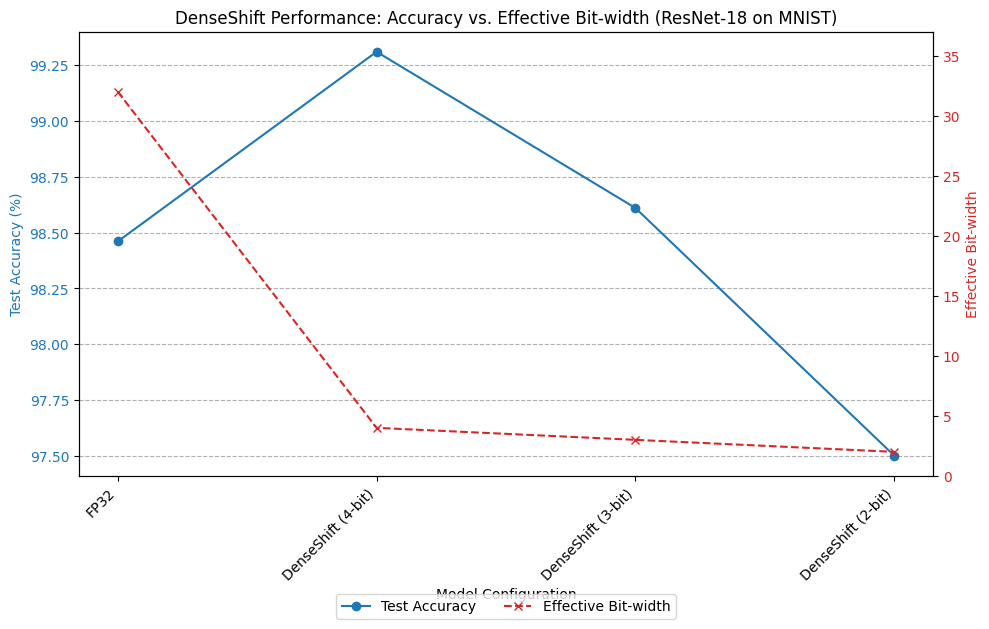

In [12]:
plot_results(config_names, results_accuracy, results_bit_width)